In [136]:
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import warnings

In [137]:
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_stopwords = default_stopwords + ['said', 'would','even','according','could','year',
                                         'years','also','new','people','old,''one','two','time',
                                         'first','last','say','make','best','get','three','make',
                                         'year old','told','made','like','take','many','set','number',
                                         'month','week','well','back']
shortword = re.compile(r'\W*\b\w{1,4}\b\d')
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
def clean_text(text, ):

    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w)>=3]

    def preprocessing_text(text):
        text = text.lower()
        text=text.replace('\n',' ').replace('\xa0',' ').replace('-',' ').replace('ó','o').replace('ğ','g').replace('á','a').replace("'"," ")
        text=re.sub(r'\d+','', text)
        text=re.sub(r'http\S+', '', text)
        text=BAD_SYMBOLS_RE.sub(' ', text)
        text=REPLACE_IP_ADDRESS.sub('', text)
        text=REPLACE_BY_SPACE_RE.sub(' ', text)
        text=' '.join(word for word in text.split() if len(word)>3)
        
        return text

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters + '0123456789')))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def stem_text(text, stemmer=default_stemmer):
        tokens = tokenize_text(text)
        return ' '.join([stemmer.stem(t) for t in tokens])

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ') # strip whitespaces
    text = text.lower() # lowercase
    #text = stem_text(text) # stemming
    text=preprocessing_text(text)
    text = remove_special_characters(text) # remove punctuation and symbols
    text = lemm_text(text) # lemmatizer
    text = remove_stopwords(text) # remove stopwords

    return text

In [138]:
df = pd.read_csv('combined_news_data.csv')

In [139]:
selected_categories = [
    'arts, culture, entertainment and media',
    'economy, business and finance',
    'politics',
    'science and technology',
    'sport'
]

In [140]:
df = df[df['category_level_1'].isin(selected_categories)]

In [141]:
df['text'] = df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)), axis=1)

In [142]:
df['text'] = df['text'].apply(clean_text)

In [143]:
y = pd.get_dummies(df['category_level_1'])

In [144]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=42,stratify=y)

In [145]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [146]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(100)
X_train_tfidf = svd.fit_transform(X_train_tfidf)
X_test_tfidf = svd.transform(X_test_tfidf)


In [147]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'estimator__C': [0.0001, 0.001, 0.01, 0.1, 1, 10,100],
    'estimator__penalty': ['l1', 'l2']
}
model = GridSearchCV(MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')),
                            param_grid,
                            cv=10,
                            scoring='f1_weighted')
# model = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))

model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

In [148]:
best_model = model.best_estimator_

# ประเมินโมเดลที่ดีที่สุด
y_pred = best_model.predict(X_test_tfidf)

# แสดงผลลัพธ์
print("Best Parameters:", model.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=y.columns))

Best Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2'}
Classification Report:
                                        precision    recall  f1-score   support

arts, culture, entertainment and media       0.88      0.92      0.90       607
         economy, business and finance       0.59      0.89      0.71       180
                              politics       0.70      0.90      0.79       280
                science and technology       0.76      0.88      0.82       330
                                 sport       0.93      0.96      0.95       282

                             micro avg       0.79      0.91      0.85      1679
                             macro avg       0.77      0.91      0.83      1679
                          weighted avg       0.81      0.91      0.85      1679
                           samples avg       0.83      0.91      0.86      1679



c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [149]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

In [150]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7740
Recall: 0.9116
F1 Score: 0.8333


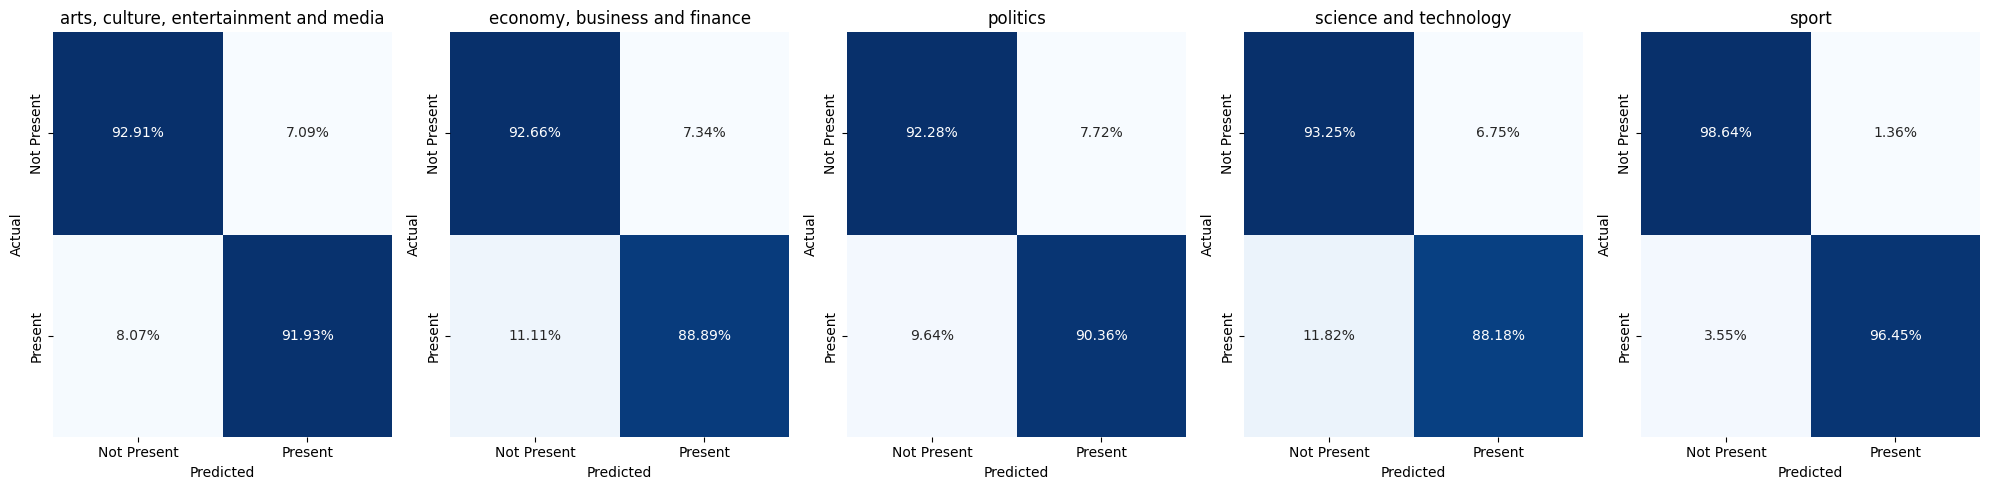

                                        precision    recall  f1-score   support

arts, culture, entertainment and media       0.88      0.92      0.90       607
         economy, business and finance       0.59      0.89      0.71       180
                              politics       0.70      0.90      0.79       280
                science and technology       0.76      0.88      0.82       330
                                 sport       0.93      0.96      0.95       282

                             micro avg       0.79      0.91      0.85      1679
                             macro avg       0.77      0.91      0.83      1679
                          weighted avg       0.81      0.91      0.85      1679
                           samples avg       0.83      0.91      0.86      1679



c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [151]:
def plot_normalized_confusion_matrix(y_true, y_pred, class_names):
    fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))
    
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(y_true.iloc[:, i], y_pred[:, i])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', ax=axes[i], cmap='Blues', cbar=False,
                    xticklabels=['Not Present', 'Present'], yticklabels=['Not Present', 'Present'])
        axes[i].set_title(class_name)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

# เรียกใช้ฟังก์ชันเพื่อแสดงผล Normalized Confusion Matrix
plot_normalized_confusion_matrix(y_test, y_pred, y.columns)
print(classification_report(y_test, y_pred, target_names=y.columns))

In [152]:
from sklearn.metrics import classification_report

# คะแนนในชุดฝึก
y_train_pred = model.predict(X_train_tfidf)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=y.columns))

# คะแนนในชุดทดสอบ
print("Testing Classification Report:")
print(classification_report(y_test, y_pred, target_names=y.columns))


Training Classification Report:
                                        precision    recall  f1-score   support

arts, culture, entertainment and media       0.87      0.93      0.90      2424
         economy, business and finance       0.57      0.89      0.69       721
                              politics       0.70      0.92      0.79      1121
                science and technology       0.77      0.91      0.83      1321
                                 sport       0.94      0.96      0.95      1126

                             micro avg       0.79      0.93      0.85      6713
                             macro avg       0.77      0.92      0.83      6713
                          weighted avg       0.80      0.93      0.86      6713
                           samples avg       0.84      0.93      0.87      6713

Testing Classification Report:
                                        precision    recall  f1-score   support

arts, culture, entertainment and media       0.88    

c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


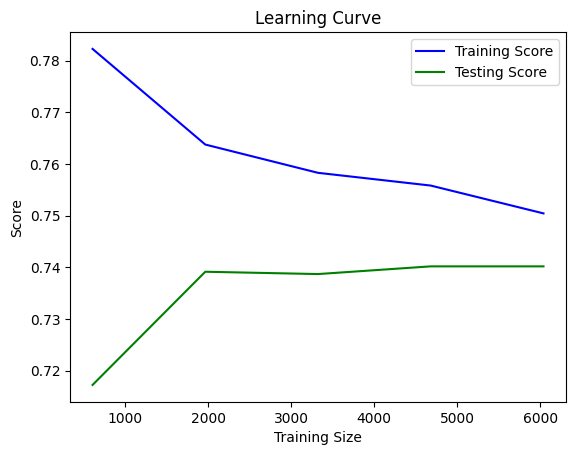

In [153]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(model.best_estimator_, X_train_tfidf, y_train, cv=10)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Testing Score', color='green')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()


In [154]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
print("Cross-validation scores:", scores)

c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-validation scores: [0.84137774 0.85312639 0.84479009 0.84823986 0.84127321]


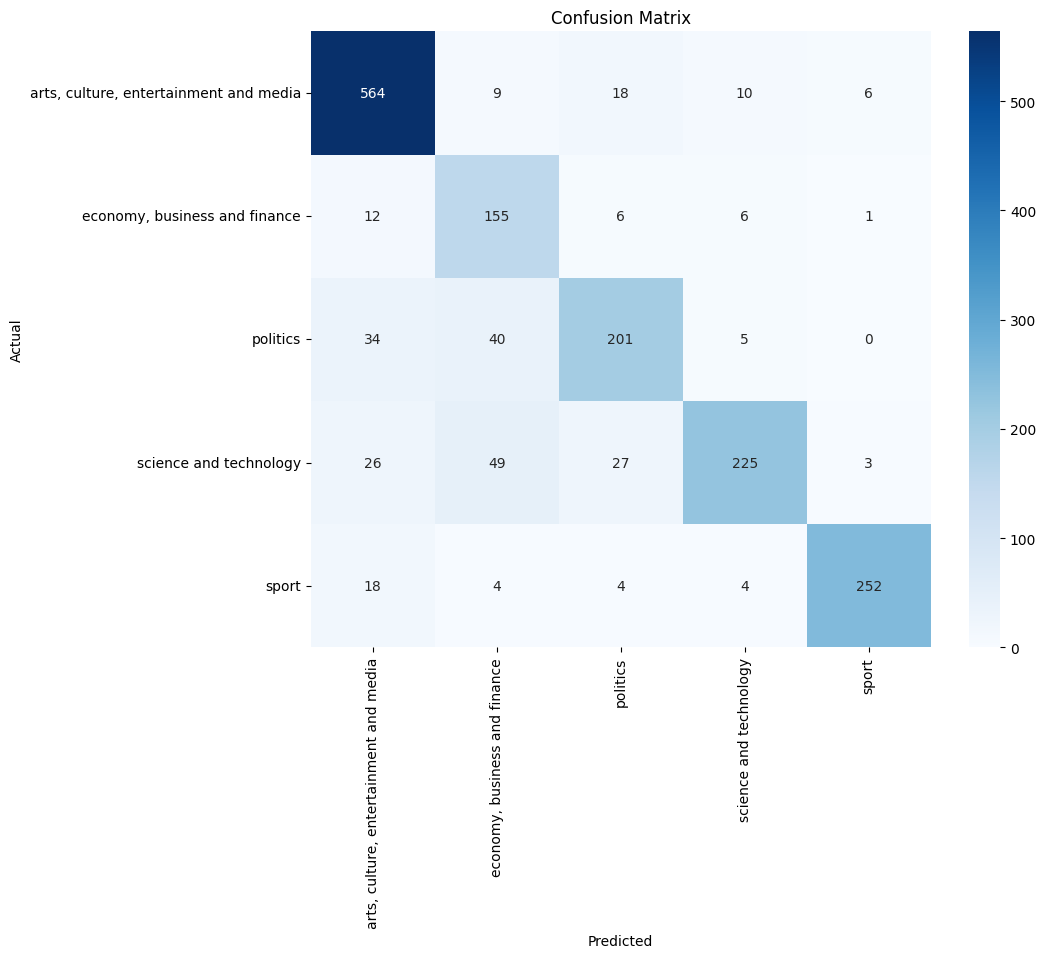

In [155]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
conf_mat = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=selected_categories, yticklabels=selected_categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_18276\1535412351.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


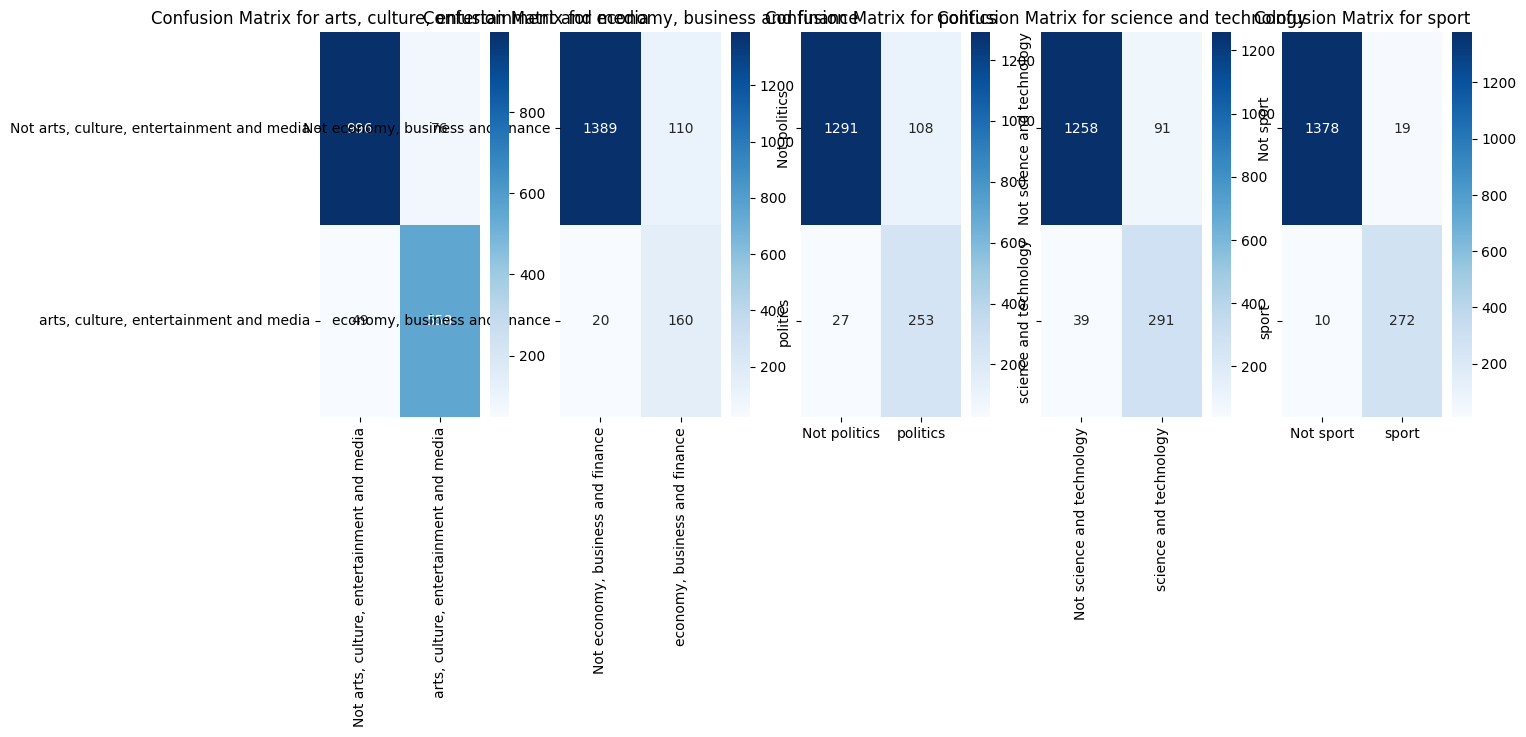

In [156]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=len(selected_categories), figsize=(15, 5))
for i, ax in enumerate(axes):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', ax=ax, 
                 xticklabels=['Not ' + selected_categories[i], selected_categories[i]],
                 yticklabels=['Not ' + selected_categories[i], selected_categories[i]])
    ax.set_title(f'Confusion Matrix for {selected_categories[i]}')
plt.tight_layout()
plt.show()


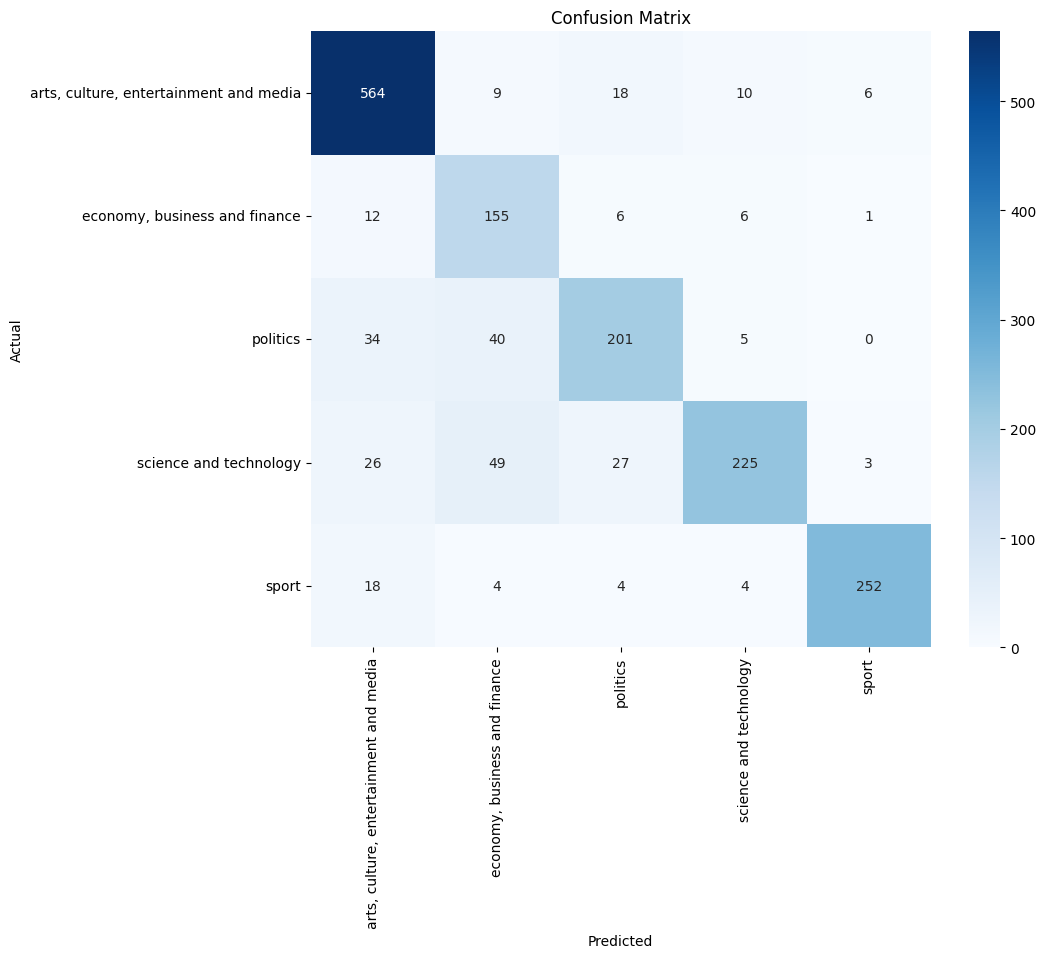

C:\Users\User\AppData\Local\Temp\ipykernel_18276\2155414053.py:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


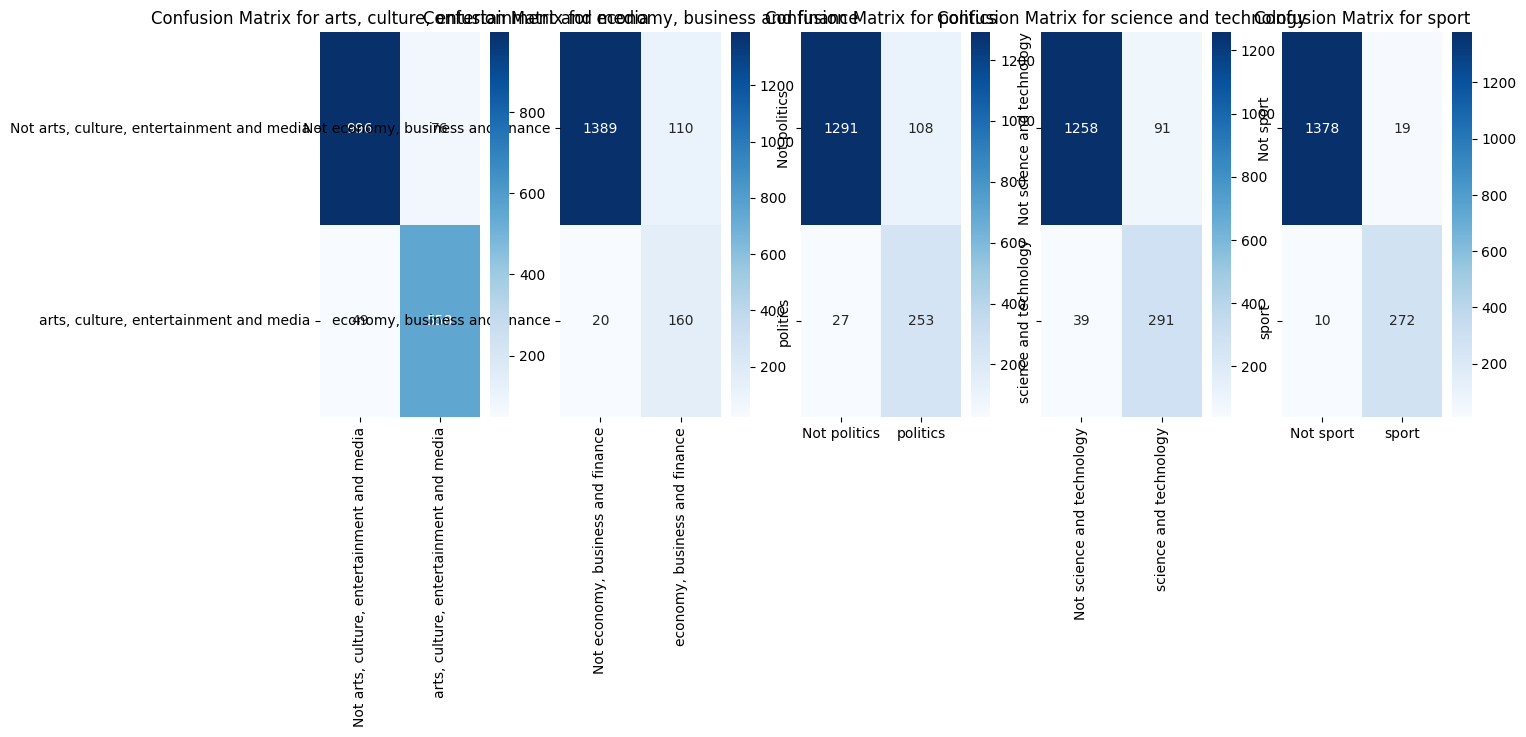

Training Classification Report:
                                        precision    recall  f1-score   support

arts, culture, entertainment and media       0.87      0.93      0.90      2424
         economy, business and finance       0.57      0.89      0.69       721
                              politics       0.70      0.92      0.79      1121
                science and technology       0.77      0.91      0.83      1321
                                 sport       0.94      0.96      0.95      1126

                             micro avg       0.79      0.93      0.85      6713
                             macro avg       0.77      0.92      0.83      6713
                          weighted avg       0.80      0.93      0.86      6713
                           samples avg       0.84      0.93      0.87      6713

Testing Classification Report:
                                        precision    recall  f1-score   support

arts, culture, entertainment and media       0.88    

c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


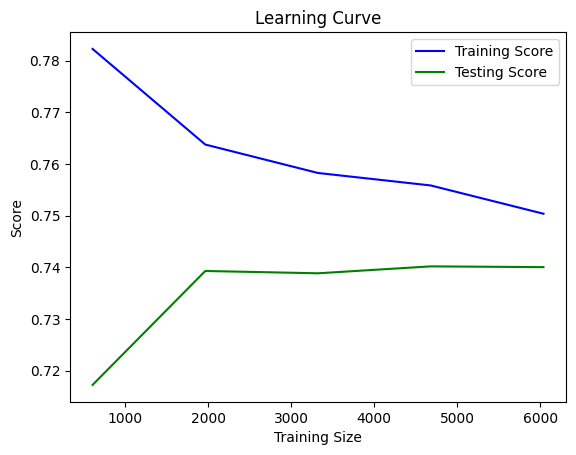

c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-validation scores: [0.84137774 0.85351433 0.84479009 0.84823986 0.84127321]


In [157]:
conf_mat = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=selected_categories, yticklabels=selected_categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Plot multilabel confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=len(selected_categories), figsize=(15, 5))
for i, ax in enumerate(axes):
    sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', ax=ax, 
                 xticklabels=['Not ' + selected_categories[i], selected_categories[i]],
                 yticklabels=['Not ' + selected_categories[i], selected_categories[i]])
    ax.set_title(f'Confusion Matrix for {selected_categories[i]}')
plt.tight_layout()
plt.show()

# Training and Testing Classification Report
print("Training Classification Report:")
y_train_pred = model.predict(X_train_tfidf)
print(classification_report(y_train, y_train_pred, target_names=y.columns))

print("Testing Classification Report:")
print(classification_report(y_test, y_pred, target_names=y.columns))

# Learning Curve
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(model.best_estimator_, X_train_tfidf, y_train, cv=10)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Testing Score', color='green')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()

# Cross-validation scores
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
print("Cross-validation scores:", scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ใช้ Random Forest Classifier เป็นทางเลือก
model = GridSearchCV(MultiOutputClassifier(RandomForestClassifier(class_weight='balanced')),
                     param_grid={
                         'estimator__n_estimators': [50, 100, 200],
                         'estimator__max_depth': [None, 10, 20],
                         'estimator__min_samples_split': [2, 5, 10]
                     },
                     cv=10,
                     scoring='f1_weighted')

model.fit(X_train_tfidf, y_train)